## CTA-Data-Challenge
By Zhihua Qi
2019.10.10

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.eval_measures import mse,rmse
from tbats import TBATS, BATS

from statsmodels.tsa.seasonal import seasonal_decompose

station = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv', 
                      index_col='date', 
                      parse_dates=True)

## Inspect the data
This Data shows daily totals of ridership, by station entry, for each 'L' station dating back to 2001.<a href='https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f'>CTA - Ridership</a> 
Dataset shows entries at all turnstiles, combined, for each station. As required, I only extracted the data from 2002-01-01 to 2017-12-31. There are mainly three steps:

- station_id and stationname matching
- missing value
- duplicates

In [2]:
station.head(10)

,station_id,stationname,daytype,rides
date,,,,
2001-01-01,40350,UIC-Halsted,U,273
2001-01-01,41130,Halsted-Orange,U,306
2001-01-01,40760,Granville,U,1059
2001-01-01,40070,Jackson/Dearborn,U,649
2001-01-01,40090,Damen-Brown,U,411
2001-01-01,40590,Damen/Milwaukee,U,870
2001-01-01,40720,East 63rd-Cottage Grove,U,391
2001-01-01,41260,Austin-Lake,U,399
2001-01-01,40230,Cumberland,U,788


In [3]:
station['index'] = station.index

In [4]:
df = station['2002-01-01':'2017-12-31']

### I first check the station_id and stationname matching situation.

In [5]:
##check the number of stations.
id = df['station_id'].nunique()
name = df['stationname'].nunique()
print('There are ', id, 'unique station ids and ', name, 'unique station names.')

There are  146 unique station ids and  147 unique station names.


#### Based on the result, the station id and station name can't match one by one. To find out all the unusual results, I filled out all the results with records number smaller than ((2017-2002+1)*365) =5840

In [6]:
tmp1 = df.groupby(['station_id', 'stationname'])['rides'].count().to_frame()
tmp1[tmp1['rides']<5840]

rides
station_id stationname                  
40140      Dempster-Skokie          2101
           Skokie                   3746
40190      Sox-35th-Dan Ryan        5814
40240      79th                     5816
40450      95th/Dan Ryan            5819
40500      Washington/State         2588
40910      63rd-Dan Ryan            5814
40990      69th                     5816
41000      Cermak-Chinatown         5818
41170      Garfield-Dan Ryan        5814
41230      47th-Dan Ryan            5817
41430      87th                     5819
41510      Morgan-Lake              2071
41680      Oakton-Skokie            2101
41690      Cermak-McCormick Place   1096
41700      Washington/Wabash         153

#### As shown above, some stations shared the same id or don't contain the full records from 2002-2017. To make the result more accurate, I remove those records.

In [7]:
df = df[(df['station_id'] != 40140)&
       (df['station_id'] != 40190)&
       (df['station_id'] != 40240)&
       (df['station_id'] != 40450)&
       (df['station_id'] != 40500)&
       (df['station_id'] != 40910)&
       (df['station_id'] != 40990)&
       (df['station_id'] != 41000)&
       (df['station_id'] != 41170)&
       (df['station_id'] != 41230)&
       (df['station_id'] != 41430)&
       (df['station_id'] != 41510)&
       (df['station_id'] != 41680)&
       (df['station_id'] != 41690)&
       (df['station_id'] != 41700)]

In [8]:
##check the number of stations.
id = df['station_id'].nunique()
name = df['stationname'].nunique()
print('There are ', id, 'unique station ids and ', name, 'unique station names.')

There are  131 unique station ids and  131 unique station names.


### I further checked the missing value situation.

In [9]:
print('There are in total', len(df), 'records in the data.')

There are in total 766158 records in the data.


In [10]:
df = df.dropna()
print('There are in total', len(df), 'records after removing missing data.')

There are in total 766158 records after removing missing data.


### I also check the duplication situation.

In [11]:
df['dupli'] = df.duplicated(['station_id', 'stationname', 'daytype', 'index'], keep=False)

In [12]:
df1 = df[df['dupli'] == True]

In [13]:
df1.head(10)

,station_id,stationname,daytype,rides,index,dupli
date,,,,,,
2011-07-01,40040,Quincy/Wells,W,6773,2011-07-01,True
2011-07-01,40060,Belmont-O'Hare,W,5004,2011-07-01,True
2011-07-01,40300,Indiana,W,920,2011-07-01,True
2011-07-01,40470,Racine,W,1656,2011-07-01,True
2011-07-01,40600,Kostner,W,374,2011-07-01,True
2011-07-01,41250,Central-Evanston,W,972,2011-07-01,True
2011-07-01,40790,Monroe/Dearborn,W,6313,2011-07-01,True
2011-07-01,40300,Indiana,W,915,2011-07-01,True
2011-07-01,40470,Racine,W,1662,2011-07-01,True


In [14]:
# an example of the duplication
tmp = df1[(df1['index'] == '2011-07-01')&(df1['stationname'] == 'Indiana')]
tmp

,station_id,stationname,daytype,rides,index,dupli
date,,,,,,
2011-07-01,40300,Indiana,W,920,2011-07-01,True
2011-07-01,40300,Indiana,W,915,2011-07-01,True


#### There are duplicated records while the rides are slightly different, so I decided to keep the first record of duplicates.

In [15]:
df = df.drop_duplicates(['station_id', 'stationname', 'daytype', 'index'], keep = 'first')
print('After removing duplicates, there are in total', len(df), 'records in data.')

After removing duplicates, there are in total 765564 records in data.


In [16]:
df = df.drop(['dupli'], axis = 1)

## Data Exploration
After visulazing some examples from the data, we confirmed that it is a time-series data. Given that, I explore the data in three different aspects.
- Statistical properties of Data
- Run an ETS Decomposition
- Tests for Stationarity

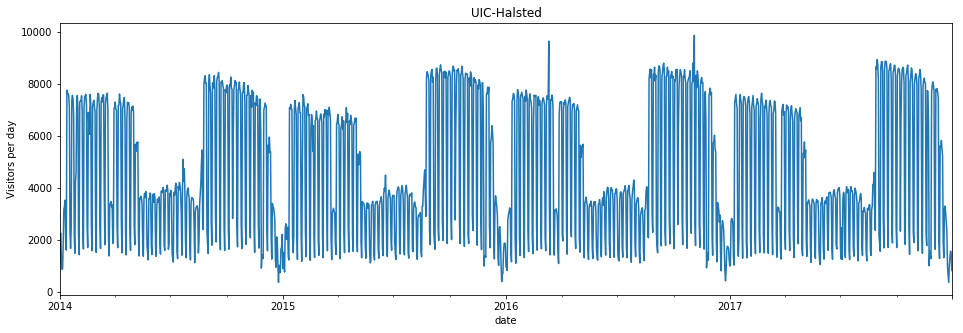

In [17]:
# draw the plots of two stations as examples
UIC_example = df[df['stationname'] == 'UIC-Halsted']['rides']

title='UIC-Halsted'
ylabel='Visitors per day'
xlabel='date'

ax = UIC_example['2014-01-01':'2017-12-31'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

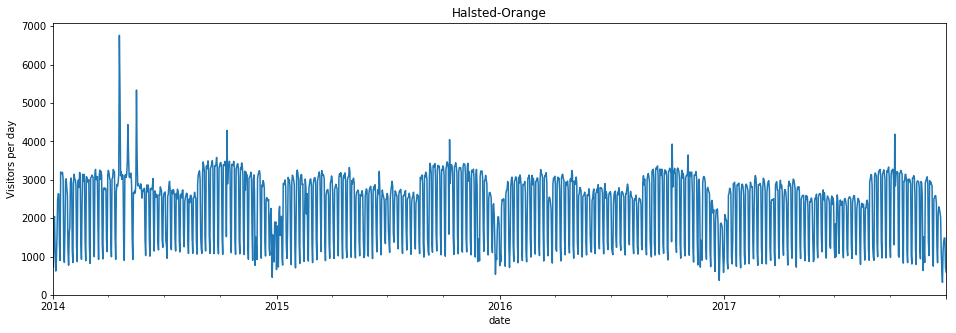

In [18]:
Halsted_example = df[df['stationname'] == 'Halsted-Orange']['rides']

title='Halsted-Orange'
ylabel='Visitors per day'
xlabel='date'

ax = Halsted_example['2014-01-01':'2017-12-31'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### As shown above, each stations have different seasonal patterns. So we should analyze the data and build the model sperately on each station. For the rest of my work, I will take station 'UIC-Halsted' as an example.

In [19]:
UIC = df[df['stationname'] == 'UIC-Halsted']
UIC.head(10)

,station_id,stationname,daytype,rides,index
date,,,,,
2002-01-01,40350,UIC-Halsted,U,393,2002-01-01
2002-01-02,40350,UIC-Halsted,W,2022,2002-01-02
2002-01-03,40350,UIC-Halsted,W,2300,2002-01-03
2002-01-04,40350,UIC-Halsted,W,2386,2002-01-04
2002-01-05,40350,UIC-Halsted,A,840,2002-01-05
2002-01-06,40350,UIC-Halsted,U,600,2002-01-06
2002-01-07,40350,UIC-Halsted,W,5109,2002-01-07
2002-01-08,40350,UIC-Halsted,W,5515,2002-01-08
2002-01-09,40350,UIC-Halsted,W,5762,2002-01-09


### Statistical properties of Data

In [20]:
UIC_result = UIC['rides'].describe()
UIC_result

count    5844.000000
mean     4164.412389
std      2399.597612
min       259.000000
25%      1904.250000
50%      3627.000000
75%      6452.250000
max      9864.000000
Name: rides, dtype: float64

### Run an ETS Decomposition

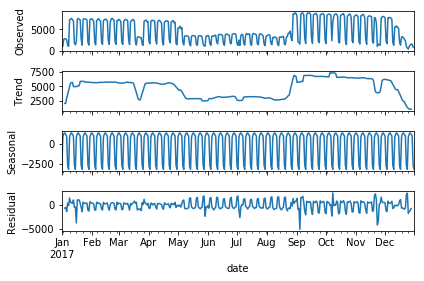

In [21]:
## weekly seasonality
UIC_1 = UIC['2017-01-01':'2017-12-31']['rides']
weekly_result = seasonal_decompose(UIC_1, model='additive')
a = weekly_result.plot()

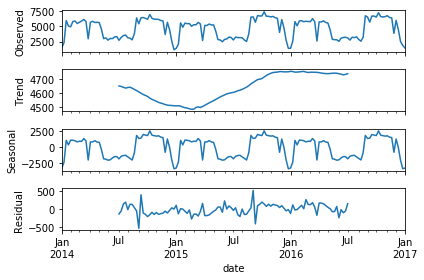

In [22]:
## yearly seasonality
UIC_2 = UIC['2014-01-01':'2016-12-31']['rides'].resample('W').mean()
yearly_result = seasonal_decompose(UIC_2, model='additive')
b = yearly_result.plot()

#### As shown aboved, the data has both the weekly and yearly seasonality.

### Tests for Stationarity

In [23]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [24]:
# Augmented Dickey-Fuller Test for weekly data
adf_test(UIC_1, title='UIC weekly data')

Augmented Dickey-Fuller Test: UIC weekly data
ADF test statistic       -1.785871
p-value                   0.387499
# lags used              14.000000
# observations          350.000000
critical value (1%)      -3.449173
critical value (5%)      -2.869833
critical value (10%)     -2.571188
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [25]:
# Augmented Dickey-Fuller Test for averaged yearly data
adf_test(UIC_2, title='UIC yearly data')

Augmented Dickey-Fuller Test: UIC yearly data
ADF test statistic     -6.335678e+00
p-value                 2.834639e-08
# lags used             1.400000e+01
# observations          1.420000e+02
critical value (1%)    -3.477262e+00
critical value (5%)    -2.882118e+00
critical value (10%)   -2.577743e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### As shown aboved, the row data is not stationary  while the averaged yearly data is stationary.

## Model fitting
As observed in previous part, the daily rides data exhibits weekly and yearly seasonal patterns. It means we are dealing with time series containing multiple seasonal effects. To solve this problem, I choose the TBATS model, which is designed for multiple seasonal effects.

In [26]:
# split train and test datasets
train = df['2002-01-01':'2016-12-31']
test = df['2017-01-01':'2017-12-31']

In [27]:
UIC_train = train[train['stationname'] == 'UIC-Halsted']['rides']
UIC_test = test[test['stationname'] == 'UIC-Halsted']['rides']

In [29]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(UIC_train)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

In [30]:
new_test = pd.DataFrame(y_forecast,index=UIC_test.index)
predictions = new_test[0].rename('TBATS Predictions')

[Text(0, 0.5, 'Rides per day'), Text(0.5, 0, '')]

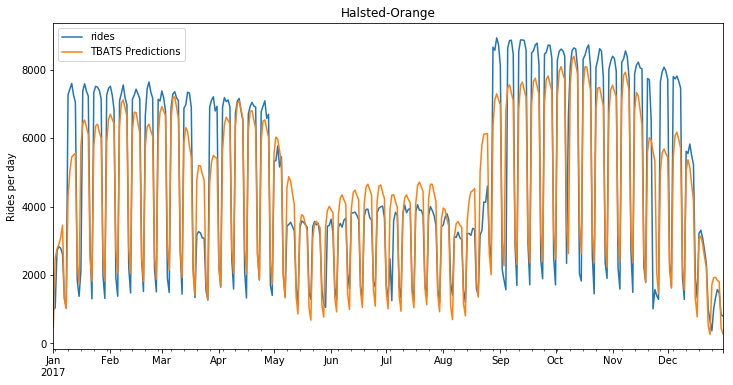

In [31]:
# Plot predictions against known values
title='Halsted-Orange'
ylabel='Rides per day'
xlabel=''

ax = UIC_test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [32]:
# Reading model parameters
print(model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 13]
ARMA errors (p, q): (5, 5)
Box-Cox Lambda 0.331706
Smoothing (Alpha): 0.293701
Seasonal Parameters (Gamma): [-3.54146662e-05  4.82106778e-05  2.75185746e-05  2.27810549e-05]
AR coefficients [ 2.75185746e-05  2.27810549e-05  2.26769913e-01 -3.25522957e-01
  1.62269246e-01]
MA coefficients [ 0.07556268 -0.18006616 -0.55825125  0.03019278 -0.30858562]
Seed vector [ 4.14971144e+01  5.04517155e+00  2.24724635e+00 -2.03251112e+00
  7.29400760e+00 -4.83377049e+00 -2.24813981e-02  1.65645139e+00
 -5.03690978e+00 -1.74289640e+00 -6.06148351e-01 -2.86513996e+00
 -1.52224710e-01 -5.71912385e-01 -1.64212511e+00 -3.46533422e-01
 -1.12256704e+00 -2.34089637e-01 -1.39810027e-01 -5.56608120e-01
 -1.46705775e+00  7.14849959e-01  1.40408190e+00  8.79461920e-01
  8.17532193e-01  7.87054477e-02  6.40123967e-01  1.06550657e+00
  8.46151757e-02  1.34593169e-01  8.19505660e-01  7.54626200e-

## Model evaluation

In [33]:
error1 = mse(UIC_test, predictions)
error2 = rmse(UIC_test, predictions)

print(f'TBATS for station UIC MSE Error: {error1:11.10}')
print(f'TBATS for station UIC RMSE Error: {error2:11.10}')

TBATS for station UIC MSE Error: 1128419.079
TBATS for station UIC RMSE Error: 1062.270718


#### Our UIC daily rides range from around 2000 to over 8000. In my opinion, this is a pretty good model so far.

### Retrain the model on the full data, and forecast the future
We're going to forecast 365 days into the future

In [34]:
UIC_total = df[df['stationname'] == 'UIC-Halsted']['rides']

In [35]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(UIC_total)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

In [36]:
date_rng = pd.date_range(start='1/1/2018', end='12/31/2018')
new_test = pd.DataFrame(y_forecast,index=date_rng)
predictions = new_test[0].rename('TBATS Predictions')

[Text(0, 0.5, 'Rides per day'), Text(0.5, 0, '')]

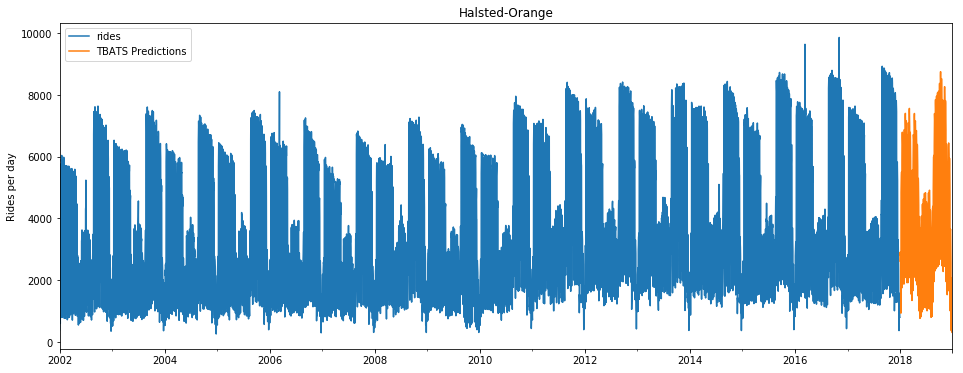

In [37]:
# Plot the forecast alongside historical values
title='Halsted-Orange'
ylabel='Rides per day'
xlabel=''

ax = UIC_total.plot(legend=True,figsize=(16,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)